In [32]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

In [33]:
REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

In [34]:
production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

In [35]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [36]:
def process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    for i, region in enumerate(REGIONS):
        data = production[production.Region == region[0]]
        data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                        on=['Year', 'Month'], how='left')

        data = pd.merge(data, area[area.Region == region[2]][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')
            
        data['Year'] = data['Year'].astype(int)
        data['Month'] = data['Month'].astype(int)
        data.reset_index(inplace=True)

        data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

        data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
        data['Time'] = np.arange(len(data))

        for lag in RAINFALL_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
            data['Rainfall_{0}'.format(lag)] = temp

        for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp
        
        PRODUCTION = data.Production
        data.drop(['Production'], axis=1, inplace=True)

        data.fillna(data.mean(), inplace=True)

        #  And finally drop rainfalls
        data.drop(['Rainfall'], axis=1, inplace=True)
        ### HERE I CAN ADD FEATURE ENGINEERING!!!

        #  And clip first year
        for col in data.columns:
            data['_'.join([region[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)
        
        output[region[1]] = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output


In [37]:
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)
DATA['Johor']

(            Johor_Month  Johor_Area_ma  Johor_Area_npa  Johor_Area_rpa  \
 1999-01-01            1     574.000000      613.000000        7.000000   
 1999-02-01            2     574.000000      613.000000        7.000000   
 1999-03-01            3     574.000000      613.000000        7.000000   
 1999-04-01            4     574.000000      613.000000        7.000000   
 1999-05-01            5     574.000000      613.000000        7.000000   
 1999-06-01            6     574.000000      613.000000        7.000000   
 1999-07-01            7     574.000000      613.000000        7.000000   
 1999-08-01            8     574.000000      613.000000        7.000000   
 1999-09-01            9     574.000000      613.000000        7.000000   
 1999-10-01           10     574.000000      613.000000        7.000000   
 1999-11-01           11     574.000000      613.000000        7.000000   
 1999-12-01           12     574.000000      613.000000        7.000000   
 2000-01-01            1 

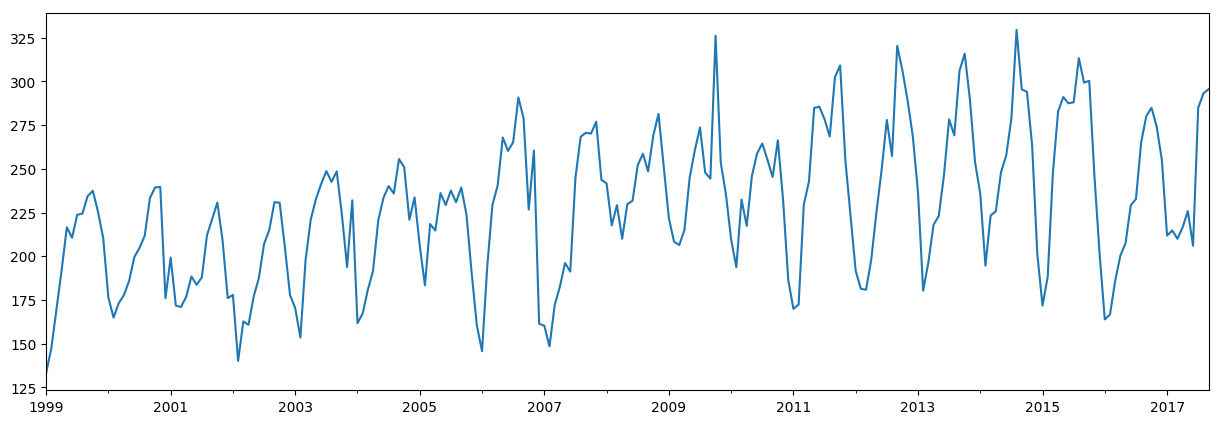

In [38]:
ts = DATA['Johor'][1]
ts.plot()

In [39]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector
from keras.layers import LSTM
from keras.optimizers import Adam, Adagrad

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe, rand

In [40]:
values = np.concatenate((DATA['Johor'][0].values, DATA['Johor'][1].values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

In [41]:
VALIDATION_SHIFT = 12
EPOCHS = 200

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

optimizer = Adagrad(0.01)

Train on 213 samples, validate on 12 samples
Epoch 1/200
 - 1s - loss: 0.2707 - val_loss: 0.3604
Epoch 2/200
 - 0s - loss: 0.2558 - val_loss: 0.3150
Epoch 3/200
 - 0s - loss: 0.2256 - val_loss: 0.2520
Epoch 4/200
 - 0s - loss: 0.1852 - val_loss: 0.1929
Epoch 5/200
 - 0s - loss: 0.1415 - val_loss: 0.1419
Epoch 6/200
 - 0s - loss: 0.1048 - val_loss: 0.1009
Epoch 7/200
 - 0s - loss: 0.0737 - val_loss: 0.0707
Epoch 8/200
 - 0s - loss: 0.0583 - val_loss: 0.0503
Epoch 9/200
 - 0s - loss: 0.0480 - val_loss: 0.0379
Epoch 10/200
 - 0s - loss: 0.0451 - val_loss: 0.0312
Epoch 11/200
 - 0s - loss: 0.0427 - val_loss: 0.0279
Epoch 12/200
 - 0s - loss: 0.0371 - val_loss: 0.0263
Epoch 13/200
 - 0s - loss: 0.0438 - val_loss: 0.0255
Epoch 14/200
 - 0s - loss: 0.0366 - val_loss: 0.0254
Epoch 15/200
 - 0s - loss: 0.0392 - val_loss: 0.0260
Epoch 16/200
 - 0s - loss: 0.0344 - val_loss: 0.0270
Epoch 17/200
 - 0s - loss: 0.0347 - val_loss: 0.0281
Epoch 18/200
 - 0s - loss: 0.0350 - val_loss: 0.0292
Epoch 19/2

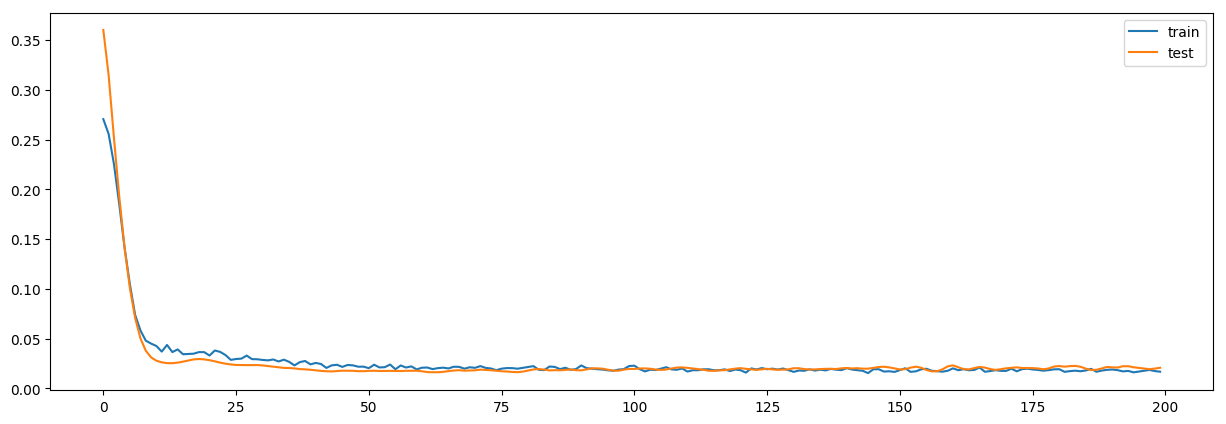

In [42]:
# reshape input to be 3D [samples, features, timesteps]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
# model.compile(loss='mae', optimizer=optimizer)
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=EPOCHS, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

Test RMSE: 28.331
Actual data:  [284.922 274.107 254.881 211.81  214.747 210.002 216.574 225.834 205.989
 284.963 293.14  295.578]
Forecast:  [270.07624842 244.89182179 224.74042372 186.45696652 186.40428852
 192.94246466 196.72486915 201.94891618 212.87054454 234.73308512
 252.73655397 268.28187222]


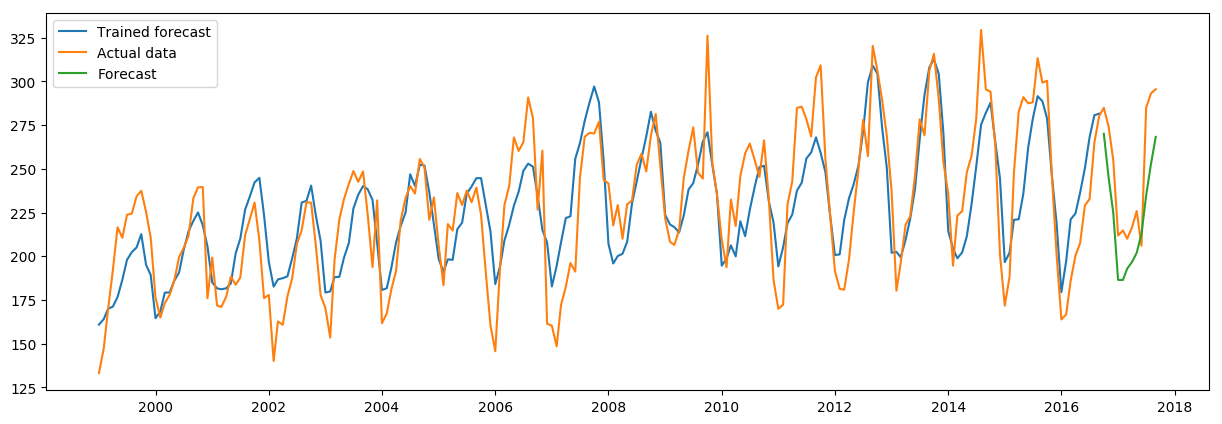

In [43]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=DATA['Johor'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA['Johor'][1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA['Johor'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.legend()

Train on 213 samples, validate on 12 samples
Epoch 1/200
 - 0s - loss: 0.2097 - val_loss: 0.0781
Epoch 2/200
 - 0s - loss: 0.0362 - val_loss: 0.0579
Epoch 3/200
 - 0s - loss: 0.0294 - val_loss: 0.0598
Epoch 4/200
 - 0s - loss: 0.0262 - val_loss: 0.0576
Epoch 5/200
 - 0s - loss: 0.0242 - val_loss: 0.0612
Epoch 6/200
 - 0s - loss: 0.0227 - val_loss: 0.0603
Epoch 7/200
 - 0s - loss: 0.0216 - val_loss: 0.0595
Epoch 8/200
 - 0s - loss: 0.0208 - val_loss: 0.0580
Epoch 9/200
 - 0s - loss: 0.0201 - val_loss: 0.0575
Epoch 10/200
 - 0s - loss: 0.0195 - val_loss: 0.0147
Epoch 11/200
 - 0s - loss: 0.0299 - val_loss: 0.1061
Epoch 12/200
 - 0s - loss: 0.0200 - val_loss: 0.0534
Epoch 13/200
 - 0s - loss: 0.0183 - val_loss: 0.0550
Epoch 14/200
 - 0s - loss: 0.0177 - val_loss: 0.0538
Epoch 15/200
 - 0s - loss: 0.0173 - val_loss: 0.0525
Epoch 16/200
 - 0s - loss: 0.0169 - val_loss: 0.0511
Epoch 17/200
 - 0s - loss: 0.0165 - val_loss: 0.0503
Epoch 18/200
 - 0s - loss: 0.0161 - val_loss: 0.0535
Epoch 19/2

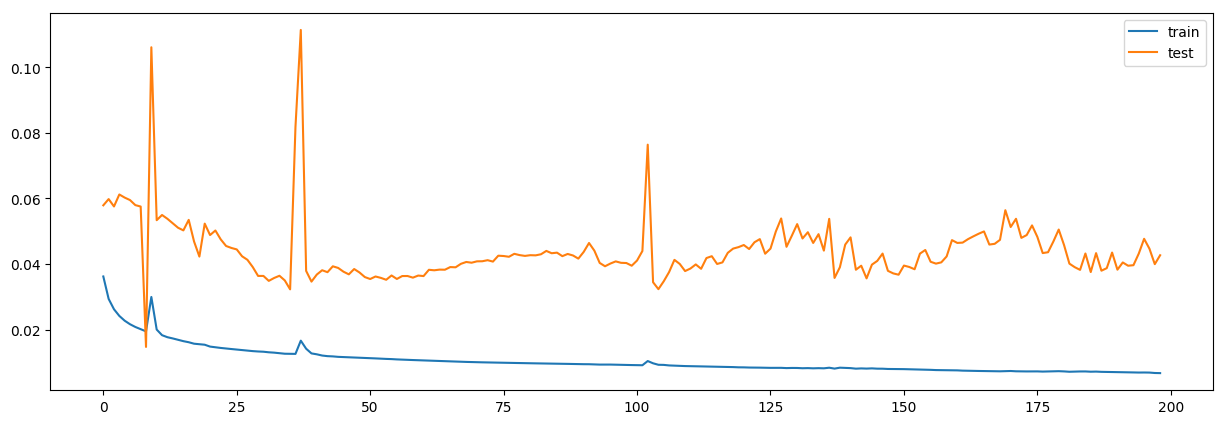

In [44]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                     input_shape=(train_X.shape[1], train_X.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizer)

history = model_cnn.fit(train_X, train_y, 
                        epochs=EPOCHS, batch_size=64, 
                        validation_data=(test_X, test_y), 
                        verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'][1:], label='train')
plt.plot(history.history['val_loss'][1:], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model_cnn.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model_cnn.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]))

Test RMSE: 40.571
Actual data:  [284.922 274.107 254.881 211.81  214.747 210.002 216.574 225.834 205.989
 284.963 293.14  295.578]
Forecast:  [265.23921293 228.85312939 207.75846679 170.07707858 177.08704793
 178.32723413 183.64224303 196.1433979  205.00065263 225.68746308
 236.97654405 247.64378935]


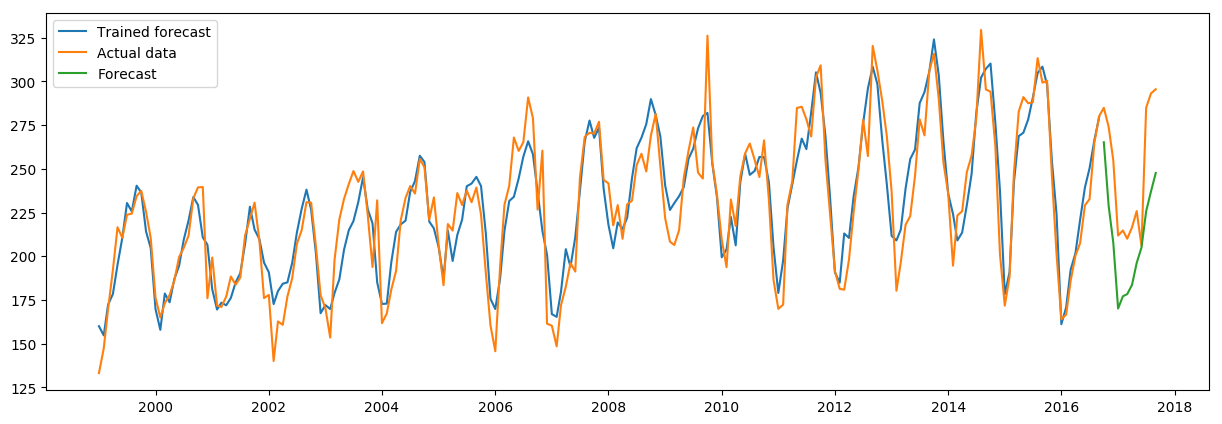

In [46]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=DATA['Johor'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA['Johor'][1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA['Johor'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.legend()